In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math
import scipy.integrate as si
import scipy.optimize as so
import os

In [2]:
# PARAMETERS
save_to_disk = False # If set to True, figure will be saved to disk. Set to False if you don't want figure to be saved to disk.

In [3]:
def second_derivative_parametric_input(x, y, t):
    # Input should be 'x' in terms 't', and 'y' in terms of 't'
    # Output is second derivative of 'y' with respect to 'x' ('d2y/dx2') as a function of 't'
    dy_dx = sp.Derivative(y, t) / sp.Derivative(x, t)
    d2y_dx2 =  sp.Derivative(dy_dx, t) / sp.Derivative(x, t)
    d2y_dx2_in_terms_of_t = sp.nsimplify(d2y_dx2.doit())

    return d2y_dx2_in_terms_of_t
    

In [4]:
c, f_NFW, x_prime = sp.symbols("c f_NFW x_prime", positive=True)
crho = 1 / (c*x_prime) / (1+c*x_prime)**2 # dimensionless density of NFW profile. 'chro = rho / rho_s', where 'rho' is the density profile and 'rho_s' is the scale radius.
psi_2 = 1/f_NFW * ( sp.log(1+c*x_prime)/x_prime - c/(1+c*x_prime) ) # normalized relative potential. This is 'psi_B' from equation (25) in our article

d2crho_dpsi2 = second_derivative_parametric_input(psi_2, crho, x_prime)  # Second derivative of 'chro' with respect to 'psi_2' as a functin of 'x_prime'

In [5]:
#Plotting the NFW profile

rho_s = 2.4796 # Msolar / pc^3
r_s = 9.6022e-5 # pc

rs = np.geomspace(1e-5, 1e-2, 40) # array of radius values
rhos_NFW = rho_s / (rs/r_s * (1+rs/r_s)**2) # density values of NFW profile corresponding to radius values

c_val = 100 # value of concetnration of NFW minihalo

f_NFW_val = math.log(1+c_val)-c_val/(1+c_val) # using equation 14

alpha_squared = 3/c_val**2 + 1/(2*f_NFW_val)*(c_val-3)/(c_val+1) # from K2021 equation (D12)
alpha = alpha_squared**(1/2)

alpha_bar_squared = (c_val**2 * math.log(100) + c_val**2 / 2 - 1/2) / f_NFW_val # this is actually 'beta^2' in our article. Formula from S2023 equation (8)
alpha_bar = alpha_bar_squared**(1/2)

beta = (c_val**3 - 2*c_val*(1+c_val)*f_NFW_val) / (2*(1+c_val)**2 * f_NFW_val**2) # this is actually gamma in our article. Formula from K2021 equation (D13)

# compute transition radius - formula below equation (9) in our article. Formula was not developed in our article.
def get_bs():
    return fb * ((2*alpha) / (3*alpha_bar))**(1/2) * ((3*M_vir) / (4*math.pi*rhoBarmh))**(1/3) 

# Compute the normalized crossover radius 'x*'
def get_x_c():
    eqn = lambda x_c: beta / alpha_squared * E_frac * x_c**2 - ( 1/f_NFW_val * ( np.log(1+c_val*x_c) / x_c  -  c_val / (1+c_val*x_c) ) ) # using equation (19) in our article
    sol = so.fsolve(eqn, 1)[0]
    
    return sol

def get_x_prime(psi_prime):
    eqn = lambda x_Prime: psi_prime  -  1/f_NFW_val * ( np.log(1+c_val*x_Prime)/x_Prime - c_val/(1+c_val*x_Prime) ) # Uses equation (25) in our article
    sol = so.root_scalar(eqn, bracket=(x_star, 1e20)).root
    
    return sol

# Compute the integrand from equation (J8) in our article
def integrand_1(psi_prime, eps, x):
    
    psi_1 = 1/f_NFW_val * ( math.log(1+c_val*x)/x - c_val/(1+c_val*x_star) ) # from equation (24) in our article
    x_prime = get_x_prime(psi_prime)

    return (
        x**2 * 1/(math.sqrt(8)*math.pi**2) * 1/np.sqrt(eps - psi_prime) * 
        d2crho_dpsi2_c_and_fNFW_substituted_lambdified(x_prime).real * np.sqrt(2*(psi_1 - eps))
    )

def range_x():
    return [0, x_star]

def range_eps(x):
    return [0, beta / alpha_squared * E_frac * x**2]

def range_psi_prime(eps, x):
    return [0, eps]


fb = 6
rhoBarmh = 18.2549e-25 # kg / m^3
b_in_kpc = 5e-5 # kpc
b = b_in_kpc * 3.086e19  # in meters
G = 6.673e-11 # m^3 / kg / s^2
m_star = 1.989e30 # kg
v_star = 200e3 # m/s
M_vir = 1.989e20 # kg

# Compute transition radius
bs = get_bs()

# Choose which formula to use by comparing 'b' to 'b_s'
if b > bs:
    E_frac = alpha_squared / (np.pi * beta) * (G * m_star**2) / (v_star**2 * b**4) / rhoBarmh
else:
    E_frac = alpha_squared / (np.pi * beta) * (G * m_star**2) / (v_star**2 * bs**4) / rhoBarmh
print(f"Efrac for b = 5e-5 kpc (right panel) is {E_frac:.2e}")

# compute normalized crossover radius 'x*'
x_star = get_x_c()

K = np.log(1 + c_val*x_star) - (c_val*x_star)/(1 + c_val*x_star) # this is just 'f_NFW(c_s * x_s*)' from equation (45) in our article

d2crho_dpsi2_c_and_fNFW_substituted = d2crho_dpsi2.subs({c:c_val, f_NFW:f_NFW_val}) # Substitute the numerical values of 'concentration' and 'f_NFW(c)' into 'd2crho_dpsi2'
d2crho_dpsi2_c_and_fNFW_substituted_lambdified = sp.lambdify(x_prime, d2crho_dpsi2_c_and_fNFW_substituted) # Lambdify 'd2crho_dpsi2_c_and_fNFW_substituted' such that it can be evaluated for a 
                                                                                                           # numerical value of 'x_prime'

I = si.nquad(integrand_1, [range_psi_prime, range_eps, range_x])[0] # equation (J8) in our article

r_0 = r_s * np.sqrt(2*K - 8*math.pi*c_val**3*I) #in Msolar / pc^3 for Hernquist. From equations (45) and (39) in our article
rho_0 = rho_s * r_s / r_0 # pc . From equation (42) in our article
rhos_Hern = rho_0 / (rs/r_0 * (1+rs/r_0)**3) # density prpfile of relaxed Hernquist minihalo 

print(f"Scale radius of Hernquist profile = {r_0:.2e} pc")
print(f"Scale density of Hernquist profile = {rho_0:.2e} Msolar / pc^3")


Efrac for b = 5e-5 kpc (right panel) is 7.80e+00
Scale radius of Hernquist profile = 1.73e-04 pc
Scale density of Hernquist profile = 1.38e+00 Msolar / pc^3


In [6]:
# Model paramters for broken power law fitted to the stabilized portion of the density profile at t= 2.5Gyr curve
rho_0_opt = 7.15846010e-01
r_0_opt = 2.46968278e-04
k_opt = 3.34342569

# Compute the density profile of the broken power law (BPL) curve using the fitted model paramters
densities_bpl = rho_0_opt / (rs / r_0_opt) / (1 + rs / r_0_opt)**k_opt

In [7]:
# This is a subset of the numerically simulated data points courtesy of Jacob Shen from the S2023 article.
# These data points are chosen from the stabilized portion of the density profile at t= 2.5Gyr curve
data_points = np.load(os.path.join('..', 'Data', 'data to model fit in S2023 Fig (7) bottom panel.npy'))

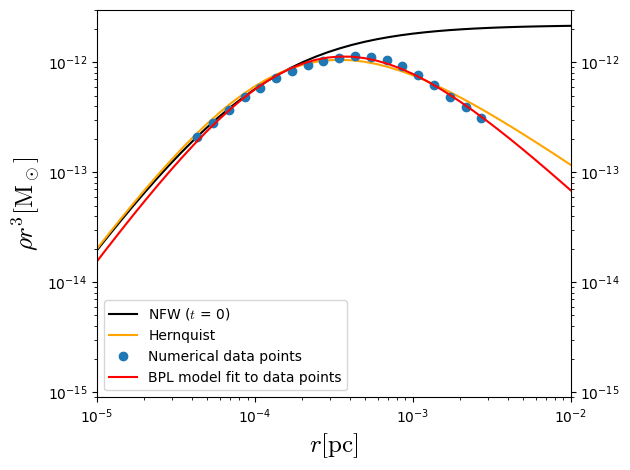

In [8]:
plt.rcParams["mathtext.fontset"] = "cm"

plt.loglog(rs, rhos_NFW*rs**3, color="black", label=r"NFW ($t$ = 0)")


plt.loglog(rs, rhos_Hern*rs**3, color="orange", label="Hernquist")

# Plot data points which were used to model fit the broken power law (BPL) profile
plt.loglog(data_points[:,0], data_points[:,1] * data_points[:,0]**3, "o", label="Numerical data points")

plt.loglog(rs, densities_bpl*rs**3, color="red", label="BPL model fit to data points")

    
plt.xlim(1e-5, 1e-2)
plt.tick_params(which="both", labelright=True, right=True)
plt.xlabel(r"$r\rm [pc]$", fontsize=18)
plt.ylabel(r"$\rho r^3[\rm M_\odot]$", fontsize=18)
plt.ylim(9e-16, 3e-12)
plt.legend(fontsize=10)
plt.tight_layout()
if save_to_disk:
    plt.savefig("Figure 4; right panel.pdf")
plt.show()

In [9]:
# Values calculated from graph above to calculate SF

mass_Hern = 4.3259849564e-11  # Mass of Hernquist profile within r_vir,s measured in solar masses
mass_BPL  = 4.23385705892e-11  # Mass of BPL profile within r_vir,s measured in solar masses
M_vir_s = 1e-10 #virial mass of NFW profile

SF_Hern = mass_Hern / M_vir_s # survival fraction computed using the Hernquist denisty profile
SF_BPL  = mass_BPL  / M_vir_s # survival fraction computed using the BPL denisty profile

# Using S2023's response function to calculate SF
c = 100
def compute_fNFW(x):
    return np.log(1 + x) - x / (1 + x)

eta = 0.987
a1 = -0.8
a2 = -0.586
a3 = -0.034
b0 = -0.583
b1 = -0.559

p = 10**( a1*(np.log10(c) - eta) + a2*(np.log10(c) - eta)**2 + a3*(np.log10(c) - eta)**3 )
k = 10**( b0 + b1*(np.log10(c) - 2) )

# Compute E_frac:
G_SI_units = 6.6743e-11 # in m^3 / kg / s^2
G = G_SI_units * (3.24078e-17)**3 / 5.02785e-31
b = 5e-2 # in parsec
m_star = 1 # in solar masses
v_star_km_s = 200 # in  km /s 
v_star = v_star_km_s * 3.24078e-14 # in parsec / second
alpha_squared = 3/c**2 + 1/(2*compute_fNFW(c))*(c-3)/(c+1)
beta = (c**3 - 2*c*(1+c)*compute_fNFW(c)) / (2*(1+c)**2 * (compute_fNFW(c))**2) # this is actually gamma in our article
rho_crit = 9.1275e-27 * 5.02785e-31 / (3.24078e-17)**3 # in Msolar / pc^3 . this is the cosmological critical density today
rho_vir = 200 * rho_crit # in Msolar / pc^3. This is the average density inside the virial radius

E_frac = alpha_squared / (np.pi * beta) * (G * m_star**2) / (v_star**2 * b**4) / rho_vir

# Using S2023's response function to calculate SF
def compute_survival_fraction(Efrac):   
    survival_fraction = 2 / ( 1+ (1 + Efrac/p)**k )
    return survival_fraction



print(f"Survival fraction of Hernquist using our model is {SF_Hern:.3g}")
print(f"Survival fraction of BPL using our model is {SF_BPL:.3g}")
print(f"Survival fraction using S2023's response function is {compute_survival_fraction(E_frac):.3g}")


Survival fraction of Hernquist using our model is 0.433
Survival fraction of BPL using our model is 0.423
Survival fraction using S2023's response function is 0.393
